### Preamble

In [77]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from scipy import linalg as la
from scipy.stats import uniform, norm
from math import isclose

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### Helper functions

In [2]:
## Helper fuunction for generating random stochastic matrices of arbuitrary size (buggy)
def to_array(neighborhood):
    arr = []
    for v, k in neighborhood.items():
        arr.append(v)
    return arr

def MCMC_PI(trials):
    x, y = 0, 0
    hits = 0
    for i in range(int(trials)):
        del_x, del_y = uniform.rvs(size=2, scale=2, loc=-1)
        if abs(x + del_x) < 1.0 and abs(y + del_y) < 1.0:
            x,y = x + del_x, y + del_y
        if x**2 + y**2 < 1.0: hits += 1
    return hits

def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

## Q7

###    1.

In [3]:
# generate a random stochastic of size n
#n = 4
#trans_mat = stoichastic_mat(n)

# Two-state markov chain
n = 2
alpha = 0.20
beta = 0.99
trans_mat = np.array([[1.0 -alpha, alpha], [beta, 1.0 - beta]])

In [4]:
matprint(trans_mat)

 0.8   0.2  
0.99  0.01  


In [5]:
# checks for normalization
for i in range(n):
    assert(isclose(sum(trans_mat[i]), 1.0, rel_tol=1e-9))

In [49]:
# calculate eigenvalues
w, vl, vr = la.eig(trans_mat, left=True)
true_stat_dist = None
tol = 1e-19
for i in range(len(w)):
    if isclose(w[i].imag, 0.0, rel_tol=tol) and isclose(w[i].real, 1.0, rel_tol=tol):
        true_stat_dist = vl[:,i]
        break
# check if the stationary distribution is found

truth_table = np.isclose(np.dot(true_stat_dist, trans_mat) - true_stat_dist, np.zeros((n,n)))

for i in range(n):
    assert(truth_table[i].all())
print(true_stat_dist)

[0.98019802 0.1980198 ]


### 2.

In [50]:
L = 1e7
nsteps = 100
sample = np.zeros(int(L), dtype="int64")
for l in range(int(L)):
    X = random.randint(0,1)
    for i in range(nsteps):
        if X == 0:
            r = random.random()
            if r >= trans_mat[0][0]:
                X = 1
        elif X == 1:
            r = random.random()
            if r < trans_mat[1][0]:
                X = 0
    sample[l] = X
    
est_stat_dist_1 = np.bincount(sample)
est_stat_dist_1 = est_stat_dist_1 / la.norm(est_stat_dist_1)
print(est_stat_dist_1)

[0.98024475 0.19778834]


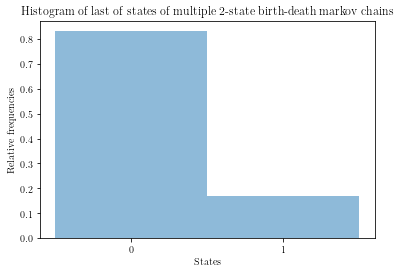

In [78]:
fig, ax = plt.subplots()
weights = np.ones_like(sample) / len(sample)
ax.hist(sample, bins=2, weights=weights, histtype='stepfilled', alpha=0.5)
ax.set_ylabel(r'Relative frequencies')
ax.set_xlabel(r'States')
ax.set_title(r'Histogram of last of states of multiple 2-state birth-death markov chains')
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(['0', '1'])
plt.show()

### 3.

In [52]:
nsteps = 1e7
sample = np.zeros(int(nsteps), dtype="int64")
sample[0] = random.randint(0,1)
for i in range(int(nsteps) - 1):
    if sample[i] == 0:
        r = random.random()
        if r >= trans_mat[0][0]:
            sample[i+1] = 1
        else:
            sample[i+1] = 0
    elif sample[i] == 1:
        r = random.random()
        if r < trans_mat[1][0]:
            sample[i+1] = 0
        else:
            sample[i+1] = 1

est_stat_dist_2 = np.bincount(sample)
est_stat_dist_2 = est_stat_dist_2 / la.norm(est_stat_dist_2)
print(est_stat_dist_2)

[0.98018145 0.19810182]


#### Comparison

In [68]:
assert(np.isclose(true_stat_dist, est_stat_dist_1, rtol=10e-3).all())
assert(np.isclose(true_stat_dist, est_stat_dist_2, rtol=10e-4).all())

The first numerical method agrees with the theoretical results up to an error tolerance of $10^{-3}$ while the second numerical method agrees with the theoreticl results up to an error tolerance of $10^{-4}$. The first numerical method a double for loop and has running time $\mathcal{O}(Ln)$ whilst the second method has a running time $\mathcal{O}(L)$ and still has results that more accurate. The second numerical method seems to be better than first method when we consider the running time and accuracy of results. 

## Q8

In [73]:
nnodes = 20
G = nx.erdos_renyi_graph(nnodes, .35)

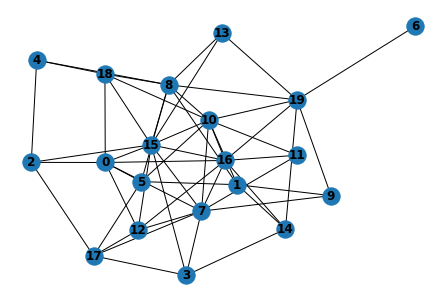

In [74]:
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

In [75]:
nsteps = 1000000
nedges = G.number_of_edges()
traj = [0]
neighborhood = to_array(G.adj[traj[0]])
for i in range(1, nsteps):
    x = random.choice(neighborhood)
    traj.append(x)
    neighborhood = to_array(G.adj[traj[i]])

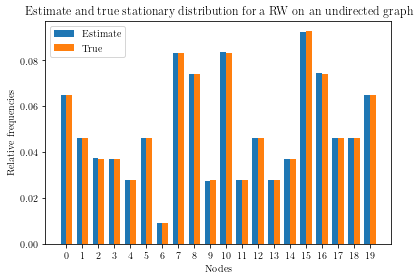

In [80]:
est_dist = np.bincount(traj) / nsteps
true_dist = [G.degree[i] / (2 * nedges) for i in range(nnodes)]
labels = ['{}'.format(i) for i in range(nnodes)]
x = np.arange(nnodes)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
ax.bar(x - width/2, est_dist, width, label=r'Estimate')
ax.bar(x + width/2, true_dist, width, label=r'True')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Relative frequencies')
ax.set_xlabel(r'Nodes')
ax.set_title(r'Estimate and true stationary distribution for a RW on an undirected graph')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()

Very good agreement between estimate and theoretical results. As expected the nodes with a higher degree are visited more often.

## Q9

### a. 
Since the above algorithm is the metropolis algorithm and acceptance ratio is based on whether the point generated is still in square or not.  The probability of being inside the square is uniform,
$p(x,y \in [-1,1]) = \frac{1}{4}$ and since we reject points outside the square we take the probability of being outisde the square as zero. We can write $f(X_{n+1})$ as

\begin{align}
f(X_{n+1}) = \left\{
\begin{array}{cc}
1/4 & \text{if } X_{n+1} \text{is inside square} \\
0   & \text{otherwise}
\end{array}\right.
\end{align}

Since all the points $\{P_i\}_i^{L}$ fall in the square. The sample generated from this metropolis algorithm be distributed according to the target probability $f(X_i) = \frac{1}{4} \quad \forall i$, which is uniformly distributed. 

### b.

In [83]:
nsteps = 6000
sample = np.zeros(int(nsteps))
for i in range(len(sample)):
    sample[i] = 4.0 * MCMC_PI(i) / (i + 1)

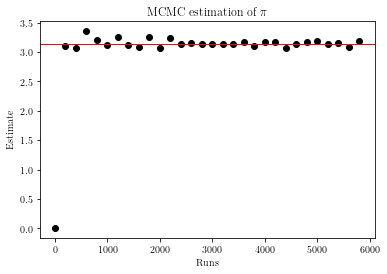

In [87]:
fig, ax = plt.subplots()
x = np.arange(nsteps)
ax.plot(x[0:nsteps:200], sample[0:nsteps:200], 'ko')
ax.axhline(y=np.pi, color='r', lw=1)
ax.set_xlabel(r'Runs')
ax.set_ylabel(r'Estimate')
ax.set_title(r'MCMC estimation of $\pi$')
plt.show()

After only a 1000 runs, estimation is already very close to the true value of $\pi$

### c.
No, we cannot construct error bars for estimator as seen in class. This is because the estimator that was seen in class has an assumption of independence between the sample of RVs, however for the above estimator the sample elements are dependent on one another, as we generate new samples based on the previous sample. More precisely the sample elements generated by the above estimator are correlated.

Usually such estimator we have to run the algorithm for sufficiently long time (dictated by the correlation time), usually called the burn-in time. After such a time the correlation between the RVs are small enough to assume independence. 